In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import geopandas as gpd
import pandas as pd
import contextily as cx
import xlrd
import os
import glob
import statsmodels.api as sm
import geopandas as gpd
import seaborn as sns
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.pyplot import cm
from functools import reduce
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy import signal
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.stats import sem
from IPython.display import display
#%matplotlib widget 
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [34]:
# All functions
def read_file( filename ):
    
    '''Read Indices Dataset from CookedFolde. Output is a dataframe of indices.   '''
    
    parent_directory = 'Indices/CookedFolder/'
    file             = filename
    df_file          = pd.read_csv(parent_directory+file+'.csv')
    
    return df_file

def qc_index1( df_raw ):
    
    ''' QC'ing JMASST data to Year and Value dataframe. '''
    
    df_jmasst_qc = df_raw.copy()
    df_jmasst_qc.columns =[ 'Year', 'sst1', 'sst2', 'sst3','sst4', 'sst5', 
                          'sst6','sst7', 'sst8', 'sst9','sst10', 'sst11', 'sst12' ]
    df_jmasst_qc = pd.wide_to_long( df_jmasst_qc,['sst'], i='Year',
                                  j='Month').reset_index().sort_values(['Year','Month'] ).reset_index()
    df_jmasst_qc['Time'] = pd.to_datetime( df_jmasst_qc[ ['Year', 'Month'] ].assign(DAY=15) )
    df_jmasst_qc['sst']  = df_jmasst_qc['sst'].div(10) 
    df_jmasst_qc.replace(99.9, np.nan, inplace=True)
    
    return df_jmasst_qc

def qc_index2( df_index_name,title ):
    
    '''Give indeces name as function. Returns date (as datetime), QC'd indeces as a dataframe. '''
    df_qc = df_index_name.copy()
    df_qc.columns = [ 'Year','ssta (°C)' ]
    df_qc['time'] = pd.DataFrame( {'time': pd.date_range('1854-01-15','2021-07-15', 
                      freq='MS').strftime('%Y-%m').tolist()} )
    df_qc['date']=pd.to_datetime( df_qc['time'] )
    df_qc = df_qc

    return df_qc

def qc_index3( df_raw ):
    
    'ERSST Clean data, eg replace 999 with nans, make sure time column is correct. Output is QCd data.'
    df_ersst_qc = df_raw.copy()
    df_ersst_qc.columns =[ 'Year', 'sst1', 'sst2', 'sst3','sst4', 'sst5', 
                          'sst6','sst7', 'sst8', 'sst9','sst10', 'sst11', 'sst12' ]
    df_ersst_qc = pd.wide_to_long( df_ersst_qc,['sst'], i="Year",
                                  j="Month").reset_index().sort_values(['Year','Month'] ).reset_index()
    df_ersst_qc['Time'] = pd.to_datetime( df_ersst_qc[ ['Year', 'Month'] ].assign(DAY=15) )
    df_ersst_qc.replace(-999.9, np.nan, inplace=True)
    
    return df_ersst_qc

def qc_index4( df_raw ):
    
    'SOI clean data, replace 999 with nans. Output is QCd data.'
    df_soi_qc = df_soi.copy()
    df_soi_qc.columns =[ 'Year', 'soi1', 'soi2', 'soi3','soi4', 'soi5', 
                          'soi6','soi7', 'soi8', 'soi9','soi10', 'soi11', 'soi12' ]
    df_soi_qc = pd.wide_to_long( df_soi_qc,['soi'], i="Year",
                                  j='Month').reset_index().sort_values(['Year','Month'] ).reset_index()
    df_soi_qc['Time'] = pd.to_datetime( df_soi_qc[['Year', 'Month']].assign(DAY=15) )
    df_soi_qc.replace(-999.9, np.nan, inplace=True)
    
    return df_soi_qc

def prepareData_HESS( folder ): 
    
    'Input is the HESS file directory. Output is dataframe with Discharge (mm/month)'
    
    directory = folder
    all_files = glob.glob(directory + '/*.xlsx')
    
    l_df = []
    l_label = ['Year']
    hess_dic = {}
    
    for filename in all_files:

        df = pd.read_excel(filename, header=0)

        # appending year and label
        temp_label = 'hess_'+df.iat[0,1].split(sep=' River')[0].lower()
        l_label.append(temp_label)
        
        # reading only needed rows and columns
        df = df.iloc[4:-1, 0:2]
        
        # changing column to date time as soon as reading it in
        df['Major River Basin'] = pd.to_datetime( df.iloc[: , 0], yearfirst = True )
        l_df.append(df)
    
    # merging based on time
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Major River Basin', how = 'outer'), l_df)

    df_final.columns = l_label
    # storing hess_labels
    hess_labels      = df_final.columns

    df_final         = df_final.sort_values(by='Year')
    
    df_final.replace( 0, np.nan, inplace = True )
    df_final = df_final.reset_index(drop=True)
    
    return df_final, hess_labels

def get_index( df ):
    
    '''Splicing Historical Data Raw Files to extract the correct columns'''
    
    df['splice'] = df.apply(lambda x: str(x['Unnamed: 12']).startswith("19") and 
                                      str(x['Unnamed: 16']).startswith("MEAN"), axis = 1)
    
    return df[df['splice']==True][['splice','Unnamed: 12']].index

def get_drainage( df ):
    
    'Getting drainage area from historical excel sheets'
    
    return df.iloc[9,6]

def prep_data( df_index,df ):
    
    '''Prepare dictionary with keys and values of location, year, data, drainage values
    Example: Historical_Maragayap dict_keys(['data', 'drainage'])
    Example: dic_data['Historical_Maragayap']['data'][1922]'''
    
    dic_temp = {}
    
    for i in df_index:
        # get year
        year=df['Unnamed: 12'].loc[i]
        
        # slicing for days
        df_temp = df.loc[i+2:i+34].dropna(axis=1, how = 'all')
        
        # dropping column
        df_temp.drop(columns=['splice'],axis=1,inplace = True)
        
        # rename columns
        df_temp.columns = df_temp.loc[i+2]
        
        # droppings unnecessary columns
        df_temp.drop([i+2,i+3], inplace = True)
        dic_temp[year] = df_temp.reset_index()
    return dic_temp

def extract_file( folder ):
    
    '''Extracting folders and files with historical data'''
    l_files =[]
    for path, subdirs, files in os.walk(folder):
        for name in files:
            if name.startswith("Phili"):
                continue
            l_files.append( os.path.join(path, name) )
            
    return l_files

def prep_rain( filename, labelname ):
    
    ' takes in file name for daily historical and mid (gridded) century rainfall and gives you monthly totals. units are mm ' 
    df_p      = pd.read_csv( filename )
    
    df_p      = df_p.iloc[2:].reset_index() \
                             .drop( columns='index' ) \
                             .rename(columns = {'Unnamed: 0':'year','Unnamed: 1':'month', 'name':'day'} ) \
                             .replace('?',-999) \
                             .replace(0.0,np.nan) \
                             .astype(float)
    
    df_p.replace(-999, np.nan, inplace=True)
    df_p.replace(0.0, np.nan, inplace = True)
    df_p.columns = [ f"{labelname}_{label.lower()}" for label in df_p.columns  ]
    df_p
    
    #df_p.apply(lambda x: f'{int(x["year"])}/{int(x["month"])}/{int(x["day"])}', axis = 1)
    df_p['Date'] = df_p.apply(lambda x: datetime.datetime( int(x[f"{labelname}_year"]), int(x[f"{labelname}_month"]), 
                                           int(x[f"{labelname}_day"])), axis = 1 )
    #df_p['Date'] = pd.to_datetime(df_p[['year', 'month','day']])
    
    df_2= df_p.resample('MS', on='Date').sum().reset_index()
    df_2.replace(0.0, np.nan, inplace = True)
    return df_2,df_2.columns

def prep_rain_mod( folder ):
    'Input is the MODERN file directory. Units are daily in inches. Output is monthly totals in mm.'
    
    directory = folder
    all_files = glob.glob( directory + '/*.xlsx' )
    
    l_df_rain = []
    l_label   = ['Date']
    rain_dic  = {}

    for filename in all_files:
        
        df = pd.read_excel( filename, header = 0 )

        df['PRCP Inch'] = df['PRCP Inch'].replace(' ',np.NaN).astype(float)
        #df['PRCP Inch'] = df['PRCP Inch'].replace(0,np.NaN).astype(float)
    
        df.replace(99.99, np.nan, inplace=True)
        df['Date'] = df.apply( lambda x: datetime.datetime( int(x['YEAR']), int(x['MONTH']), int(x['DAY']) ), axis = 1 )

        df['Prpmm'] = df['PRCP Inch'] 
        
        df_mon_sum  = df.resample('MS', on = 'Date').sum().reset_index()
        df_mon_sum.replace(0.0, np.nan, inplace = True)
        df_mon_sum.replace(0.00, np.nan, inplace = True)
        df_2        = df_mon_sum.drop( ['YEAR','MONTH','DAY', 'PRCP Inch'],axis = 1 )
        l_df_rain.append(df_2)
        
        # appending year and label
        temp_label = f"mod_{filename.split('/')[-1].split('.')[0].lower()}"
        l_label.append(temp_label)
    #print( sorted(l_label) ) 
    #print(len(l_label))
    df_final_rain = reduce( lambda left,right: pd.merge( left,right,on='Date', how='outer' ), l_df_rain )
    df_final_rain = df_final_rain.drop(['Unnamed: 4_x','Unnamed: 4_y','Unnamed: 4'],axis = 1)
    #display( df_final_rain.info() )
    df_final_rain.columns = l_label
    #display(df_final_rain.head())
    
    return df_final_rain,l_label
    
def historical_dishcarge( dict ):
    
    ' Save dict of drainage data as a dataframe, all historical sites and monthly discharge values in mm/month'
    for k,v in dict_data.items():
        dict_final[k] = [] 
        #dict_new_keys = 
        for year,df_daily in v['data'].items():
            # Change from l/sec (instantaneous) to mm/month
            # [ [ Q (mean discharge) / A (drainage area) ] * 3600 * 24 * n of days ] / 10^6
            dic_days = {1:31, 2:[28,29], 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
            df_discharge = df_daily.copy()
            df_discharge = ( (( ( df_discharge.mean()/v['drainage'] ) * 0.0864 * 30)).to_frame() )
            df_discharge = df_discharge.iloc[2: , :]
            df_discharge.columns = [k]
            df_discharge.index.names = ['Year']
            df_discharge.reset_index(inplace=True)
            look_up = {'JAN':1, 'FEB':2,  'MAR':3, 'APR':4,'MAY':5,
                       'JUN':6, 'JUL':7, 'AUG':8 , 'SEPT':9,'OCT':10, 'NOV':11, 'DEC':12}
            df_discharge['Year'] = df_discharge['Year'].map(lambda x: look_up[x])
            df_discharge['Year'] = df_discharge['Year'].map(lambda x: datetime.datetime(year,x,1))
            dict_final[k].append( df_discharge )

        dict_final[k] = pd.concat(dict_final[k]).reset_index(drop=True)
    
    return dict_final

def clean_data(df,crit_data,crit_label,criteria_name, criteria_number,date_name, color_plot):
    'CPE : Coast(1),Plain(2), Elevation(3)'
    'Climate Type: 1, 2, 3, 4'
    'Cluster Type: 1, 2, 3, 4, 5, 6'
    temp_df = df

    #display( temp_df )
    df_select  = crit_data[(crit_data[criteria_name] == criteria_number) ]
    #print(df_select)
    df_name    = list(df_select[crit_label])
    print(df_name)
    print()
    print(f'n={len(df_name)}')
    
    # take the mean of the data that meet criteria
    df_mean         = pd.DataFrame( temp_df[df_name].mean(axis=1) )
    df_mean.columns = ['data_mean']
    df_mean['date'] = temp_df[date_name]
    df_mean = df_mean.dropna().reset_index( drop=True )
    #display( df_mean.tail(10) )
    
    # std dev 
    np_std         = np.nanstd( temp_df[df_name], axis = 1 )
    #print(np_std)
    df_std         = pd.DataFrame(np_std,columns = ['data_std'] )
    df_std['date'] = temp_df[date_name]
    df_std         = df_std.dropna().reset_index( drop=True )
    #display(df_std.tail(10))
    df_mean['std'] = df_std['data_std']
    
    # log scale of mean values
    df_mean['data_log']    = pd.DataFrame( (np.log10(df_mean['data_mean'])) )
    #df_mean['data_log_std']= pd.DataFrame( (np.log10(df_mean['std']) ) )
    #display( df_mean.head(300) )
    
    # scale data 
    scaler = StandardScaler()
    df_mean['data_scaled']      = scaler.fit_transform( df_mean['data_log'].values.reshape(-1,1) )
    #df_mean['data_scaled_std']  = scaler.fit_transform( df_mean['data_log_std'].values.reshape(-1,1) )
    
    # detrend mean values  using fit and substract 
    X = [i for i in range( 0, len(df_mean['data_log']) ) ]
    X = np.reshape( X, (len(X), 1) )
    y = df_mean['data_scaled'].values
    # chi square useful for testing model assumptions rather than comparing models.
    pf = PolynomialFeatures(degree=3)
    Xp = pf.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X, y)
    
    md2 = LinearRegression()
    md2.fit(Xp, y)
    
    trend = model.predict(X)
    trendp = md2.predict(Xp)
    
    plt.plot(y)
    plt.plot(trendp)
    plt.ylabel('Scaled Data')
    plt.title('Polynomial Trend')
    plt.show()
    df_mean['data_detrend_L'] = [ y[i]-trend[i] for i in range( 0,len(df_mean['data_log']) )]
    df_mean['data_detrend_P'] = [y[i] - trendp[i] for i in range(0, len(df_mean['data_log']) )]
    # add r2 for goodness of fit between detrend_P and original data, chi2 (how similar the data is)
    #stats.chisquare(f_obs=df_mean['data_scaled'], f_exp=df_mean['data_detrend_P'])
    
    plt.plot(df_mean['data_detrend_P'])
    plt.ylabel('Scaled Data')
    plt.title('Residual:Trend substracted from data')
    plt.show()
    
    # REMOVE SEASONALITY 
    df_mean['data_deseason'] = df_mean['data_detrend_P'].rolling(window=6, center=True).mean()
    df_mean['data_deseason12'] = df_mean['data_detrend_P'].rolling(window=12, center=True).mean()[6:-6]
    #display(df_mean.head(100))
    
    # merge with ENSO 3.4arel index 
    df_final = df_mean.merge(df_nino34a_rel_qc, how = 'outer', on = 'date', validate = '1:1' )
    df_final = df_final.sort_values( 'date' ).reset_index(drop=True)
    df_final = df_final.dropna().reset_index(drop=True)
    #df_final.to_csv(f'../discharge/Data/Images/Nov18/{criteria_name}_{criteria_number}_{crit_label}', encoding='utf-8', index=False)
    std_err = 0.3
    
    fig = plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)
    plt.plot(df_final['date'], df_final['data_mean'], label = 'x')
    plt.title('Mean of Subset Data')
    plt.ylabel('mm/month')
    plt.xlabel('Time')
    plt.subplot(1,3,2)
    plt.plot(df_final['date'], df_final['data_log'])
    plt.title('Log of Subset Data (Mean)')
    plt.ylabel('Log of Data')
    plt.xlabel('Time')
    plt.subplot(1,3,3)
    plt.plot(df_final['date'], df_final['data_scaled'])
    plt.title('Scale of Subset Data (Log)')
    plt.ylabel('Scaled Data')
    plt.xlabel('Time')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(df_final['date'], df_final['data_scaled'], label = 'data_scaled')
    plt.plot(df_final['date'], df_final['data_detrend_P'], label = 'data_detrend_P' )
    plt.plot(df_final['date'], df_final['data_deseason'],label = 'data_deseason_6')
    plt.plot(df_final['date'], df_final['data_deseason12'],label = 'data_deseason_12')
    plt.ylabel('Scaled De-Trend and De-Season Discharge (monthly)')
    plt.xlabel('Time')
    plt.legend(loc=4)
    plt.show()

    #### CLEAN DATA FIGURES
    
    fig, ax1 = plt.subplots(figsize=(15,7))
    ax2 = ax1.twinx()
    ax1.plot(df_final['date'],df_final['data_deseason12'],
         color=color_plot,linewidth = 1,label = f'{criteria_name} {criteria_number} (± 6 months) ({crit_label})') ######
    ax1.plot(df_final['date'],df_final['data_deseason'],
         color=color_plot,linestyle='dashed',linewidth = 1, alpha = 0.5,label = f'{criteria_name}  {criteria_number} (± 3 months) ({crit_label})') ######
    ax1.set_ylabel(f'Scaled Logged De-Trend and De-Season {crit_label} (monthly)')
    ax1.set_ylim(-3,3)
    ax1.set_xlabel('Time (CE)')
    ax2.bar(df_final['date'],df_final['ssta (°C)']
        , width = 30,color=(df_final['ssta (°C)'] > 0).map({True: 'r',False: 'b'}),alpha = 0.7)
    ax2.set_xlim(pd.Timestamp('1900-02-15'), pd.Timestamp('2019-07-01'))
    ax2.set_ylim(-3,3)
    ax2.set_ylabel('Nino 3.4 rel (°C)', color='k')
    ax2.set_xlabel('Time (CE)')
    ax1.legend(loc='best')
    #plt.savefig(f'{criteria_name}_{criteria_number}_{crit_label}.png',dpi=600) #######
    plt.show()

    ## Plotting climatology 
    df_final['month'] = pd.to_datetime( df_final['date'] ).dt.to_period('M')

    df_final['data_mean'].groupby( df_final['month'].dt.month ).median().plot( kind='bar',color=color_plot ) ######
    plt.xlabel('Months')
    plt.ylabel(f'{crit_label} monthly means (mm/month)')
    plt.title(f'{criteria_name} {criteria_number}')
    #plt.savefig(f'../discharge/Data/Images/Nov18/Test_{criteria_name}_{criteria_number}_{crit_label}.png', dpi = 600)
    #plt.savefig(f'Mean_{criteria_name}_{criteria_number}_{crit_label}.png', dpi = 600)
    plt.show()

    return df_final, std_err

def slide_func(thresh,df,std_err, index_unit,data_name,lag,window,index_name):
    ' Sliding Function '
    df = df.copy()
    #df = df.dropna()
    df[ index_name ] = df[index_unit].map( lambda x:1 if thresh[1] <= x <= thresh[0] else 0 )  ############################
    #display(df[ 'elnino' ])
    l_idx_elnino = df[df[index_name] == 1].index.values
    df_data =[]
    for n, idx in enumerate(l_idx_elnino): 
        
        df_tmp = df.loc[ idx ]
        hor =(df_tmp[index_unit])
        ver = (df_tmp['date'])
        start = idx - (6*lag)
        df_tmp = df.loc[ start: start+window  ]
        #display( df_tmp.head() )
        fig = plt.figure(figsize=(5,5))
        host = host_subplot(111, axes_class=AA.Axes)
        plt.subplots_adjust(right=0.95)

        par1 = host.twinx()

        new_fixed_axis = par1.get_grid_helper().new_fixed_axis
        par1.axis['right'] = new_fixed_axis( loc='right', axes=par1,offset=(0, 0) )
           
        host.set_xlabel('Time')
        host.set_ylabel('SSTA (°C)')  
        host.set_ylim(-3, 3)
        par1.set_ylabel('Rain Data (Unitless)')
        par1.set_ylim(-3, 3)

        corr, _ = pearsonr(df_tmp[index_unit], df_tmp[data_name])
        y_std_err = ( std_err )
        #print(y_std_err)
        
        p1 = host.bar(df_tmp['date'],df_tmp[index_unit],width = 40,color=(df_tmp[index_unit] > 0).map({True: 'r',False: 'b'}) , alpha = 0.5)
        
        #plot(df_tmp['date'], df_tmp[index_unit],'sb-')
        p2, = par1.plot(df_tmp['date'], df_tmp[data_name],color='black',linewidth = 2) ##############
        
        par1.axis['right'].label.set_color(p2.get_color())
        
        plt.axhline(hor, color='k', linestyle='--')
        plt.axvline(ver, color='k', linestyle='--')
        plt.setp(host.axis['bottom'].major_ticklabels, rotation=35)
        plt.tight_layout()
        plt.title(f'{index_name} between {thresh}, ssta = {hor:.3},event = {ver}, r value ={corr:.3} ')
        #plt.savefig(f'Oct18LaNina/CPE III LN idx:{idx}.png')
        plt.show()
        
        df_data = [hor,ver]
        
    return df_data

def add_basemap(ax, zoom, url):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = cx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))

In [3]:
# Reading in raw data
# list of indices: 'ersst' 'jmasst' 'meiv2' 'nina12a_rel' 'nina3a_rel' 'nina34_rel' 'nina4a_rel'
# 'nina4a' 'nina34a' 'nina3a' 'nina12a' 'soi' 'PDO'
df_nino34arel      = read_file( 'nino3.4a_rel' )
df_nino34a         = read_file( 'nino3.4a' )

# Reduced NINO INDICES
df_nino34a_qc     = qc_index2( df_nino34a,'NINO 3.4' )
df_nino34a_rel_qc = qc_index2( df_nino34arel,'NINO 3.4 REL' )

In [4]:
# RAINFALL DATA 
df_rain_mod, rain_mod_label  = prep_rain_mod( 'Modern/' )

# Rainfall Data (historic + mid century)
df_rain_hist,df_rain_hist_label = prep_rain('../discharge/Data/Files/1901_1940Rainfall.csv','hist')


df_rain_mid,df_rain_mid_label  = prep_rain('../discharge/Data/Files/Rainfall1951_1990.csv','mid')

# Clean names
rain_list_mod = [ key.split('mod_')[-1].lower() for key in df_rain_mod.columns ]
rain_list_mod.remove('date')

rain_list_mid = [ key.split('mid_')[-1].lower() for key in df_rain_mid.columns ]
del rain_list_mid[0:4]

rain_list_hist= [ key.split('hist_')[-1].lower() for key in df_rain_hist.columns ]
del rain_list_hist[0:4]

In [5]:
# MERGING RAINFALL DATA (MOD + HIST)
pd.set_option('display.max_columns', None)

df_rain_mod_copy = df_rain_mod.copy( )
#display(df_rain_mod_copy .head())
df_rain_mod_his   = []
rain_drop_list   = [
                    'mod_ambulong', 'mod_aparri', 'mod_baguio', 'mod_borongan', 'mod_butuan', 'mod_cabanatuan', 'mod_calapan', 'mod_casiguran', 
                    'mod_catbalogan', 'mod_clark', 'mod_davao', 'mod_dipolog', 'mod_dumaguete','mod_gen', 'mod_hinatuan', 'mod_iloilo', 'mod_laoag', 
                    'mod_lumbia', 'mod_maasin', 'mod_mactan', 'mod_manila', 'mod_surigao', 'mod_tagbilaran', 'mod_tuguegarao', 'mod_vigan',
                    'hist_ambulong', 'hist_aparri', 'hist_baguio', 'hist_borongan', 'hist_butuan', 'hist_cabanatuan', 'hist_calapan', 
                    'hist_casiguran', 'hist_catbalogan', 'hist_clark', 'hist_davao', 'hist_dipolog', 'hist_dumaguete', 'hist_gen', 
                    'hist_hinatuan', 'hist_iloilo', 'hist_laoag', 'hist_lumbia', 'hist_maasin', 'hist_mactan', 
                    'hist_manila', 'hist_surigao', 'hist_tagbilaran', 'hist_tuguegarao', 'hist_vigan', 
                    
                   ]

for rain_name_clean, rain_name in zip( rain_list_hist,df_rain_hist.columns.drop(['Date','hist_year','hist_month','hist_day']) ):
    #print(rain_name_clean, rain_name)
    if rain_name_clean in rain_list_mod:
        #print(rain_name_clean, rain_list_mod)
        if f"{ rain_name_clean }" in f"{ rain_list_mod }":
            #print(rain_name_clean, rain_list_mod)
            #print(rain_name)
            mod_labels_clean = 'mod_'+rain_name_clean
        df_rain_mod_copy=df_rain_mod_copy.merge( df_rain_hist[['Date',rain_name]], how = "outer", on = 'Date',  validate = '1:1' )
        #display(df_rain_mod_copy.head())
        
        df_rain_mod_copy[rain_name_clean] = df_rain_mod_copy[f"{mod_labels_clean}"].combine_first(
                                                      df_rain_mod_copy[f"{rain_name}"])
        #display( df_rain_mod_copy.head() )
        df_rain_mod_copy=df_rain_mod_copy.sort_values('Date').reset_index(drop=True)  
        
    else:
        #print(f'**{river_name_clean}')
        #print(f'**{river_name}')
        df_rain_mod_copy = df_rain_mod_copy.merge(df_rain_hist[['Date',rain_name]], how = 'outer', on = 'Date', validate = '1:1' )
        df_rain_mod_copy=df_rain_mod_copy.sort_values('Date').reset_index(drop=True)
       



df_rain_mod_hist = df_rain_mod_copy
df_rain_mod_hist_dropped = df_rain_mod_hist.drop(rain_drop_list , axis =1 )
df_rain_mod_hist_dropped.rename( columns={
    'Date':'Date','ambulong': 'mod_hist_ambulong', 'aparri': 'mod_hist_aparri', 'baguio': 'mod_hist_baguio', 'borongan': 'mod_hist_borongan','butuan':'mod_hist_butuan' ,'cabanatuan':'mod_hist_cabanatuan',
    'clark': 'mod_hist_clark', 'dipolog': 'mod_hist_dipolog','davao':'mod_hist_davao','dumaguete':'mod_hist_dumaguete', 'gen': 'mod_hist_gen', 'hinatuan': 'mod_hist_hinatuan','hist_malaybalay':'mod_hist_malaybalay',
    'hist_munoz':'mod_hist_munoz', 'iloilo':'mod_hist_iloilo', 'laoag':'mod_hist_laoag', 'lumbia':'mod_hist_lumbia', 'maasin':'mod_hist_maasin', 'mactan':'mod_hist_mactan',
    'manila':'mod_hist_manila', 'mod_cotabato':'mod_hist_cotobato', 'mod_daet':'mod_hist_daet', 'mod_daniel':'mod_hist_daniel', 'surigao':'mod_hist_surigao',
    'tagbilaran':'mod_hist_tagbilaran', 'tuguegarao':'mod_hist_tuguegarao', 'vigan':'mod_hist_vigan','calapan':'mod_hist_calapan', 'casiguran':'mod_hist_casiguran','catbalogan':'mod_hist_catbalogan'
                                        }, inplace=True )
print( sorted(df_rain_mod_hist_dropped.columns) )
#display(df_rain_mod_hist_dropped.head())

['Date', 'mod_hist_ambulong', 'mod_hist_aparri', 'mod_hist_baguio', 'mod_hist_borongan', 'mod_hist_butuan', 'mod_hist_cabanatuan', 'mod_hist_calapan', 'mod_hist_casiguran', 'mod_hist_catbalogan', 'mod_hist_clark', 'mod_hist_cotobato', 'mod_hist_daet', 'mod_hist_daniel', 'mod_hist_davao', 'mod_hist_dipolog', 'mod_hist_dumaguete', 'mod_hist_gen', 'mod_hist_hinatuan', 'mod_hist_iloilo', 'mod_hist_laoag', 'mod_hist_lumbia', 'mod_hist_maasin', 'mod_hist_mactan', 'mod_hist_malaybalay', 'mod_hist_manila', 'mod_hist_munoz', 'mod_hist_surigao', 'mod_hist_tagbilaran', 'mod_hist_tuguegarao', 'mod_hist_vigan']


In [6]:
# MERGING RAINFALL DATA : MOD + HIST (df_rain_mod_hist) + MID 

# clean the dropped list, use that to compare with mid dataset

df_rain_mod_hist_dropped_copy = df_rain_mod_hist_dropped.copy()

rain_list_mod_hist = [ key.split('_')[-1].lower() for key in df_rain_mod_hist_dropped.columns ]
rain_list_mod_hist.remove('date')

df_rain_mod_his_mid = []
rain_drop_list = [
                'mid_ambulong', 'mid_aparri', 'mid_baguio', 'mid_borongan','mid_butuan','mid_cabanatuan', 'mid_calapan', 'mid_casiguran', 'mid_catbalogan', 'mid_clark','mid_cotobato','mod_hist_cotobato',
                'mid_daet', 'mid_daniel', 'mid_dipolog', 'mid_dumaguete', 'mid_gen', 'mid_hinatuan', 'mid_laoag', 'mid_maasin', 'mid_malaybalay', 'mid_manila', 'mid_surigao', 'mid_tagbilaran', 'mid_tuguegarao', 
                'mid_vigan', 'mod_hist_ambulong', 'mod_hist_aparri', 'mod_hist_baguio', 'mod_hist_borongan','mod_hist_butuan', 'mod_hist_cabanatuan', 'mod_hist_calapan', 'mod_hist_casiguran', 'mod_hist_catbalogan', 'mod_hist_clark',
                'mod_hist_daet', 'mod_hist_daniel', 'mod_hist_dipolog','mod_hist_dumaguete','mod_hist_hinatuan','mod_hist_laoag','mod_hist_maasin', 'mod_hist_malaybalay','mod_hist_manila','mod_hist_gen',
                'mod_hist_surigao', 'mod_hist_tagbilaran', 'mod_hist_tuguegarao', 'mod_hist_vigan',
                 ]

for rain_name_clean_mid, rain_name_mid in zip( rain_list_mid,df_rain_mid.columns.drop(['Date','mid_year','mid_month','mid_day']) ):
    if rain_name_clean_mid in rain_list_mod_hist:
        if f"{ rain_name_clean_mid }" in f"{ rain_list_mod_hist }":
            merged_labels_clean = 'mod_hist_' + rain_name_clean_mid
            #print(merged_labels_clean)
        df_rain_mod_hist_dropped_copy = df_rain_mod_hist_dropped_copy.merge( df_rain_mid[['Date', rain_name_mid]], how = 'outer', on = 'Date', validate = '1:1' )
        #display( df_rain_mod_hist_dropped_copy.head() )
        df_rain_mod_hist_dropped_copy[rain_name_clean_mid] = df_rain_mod_hist_dropped_copy[f"{merged_labels_clean}"].combine_first(
                                        df_rain_mod_hist_dropped_copy[f"{rain_name_mid}"] )
        df_rain_mod_hist_dropped_copy = df_rain_mod_hist_dropped_copy.sort_values('Date',axis=0).reset_index(drop=True)  
        #display( df_rain_mod_hist_dropped_copy.head() )
        
    else:
        #print(f"{ rain_name_clean_mid }")
        df_rain_mod_hist_dropped_copy = df_rain_mod_hist_dropped_copy.merge(df_rain_mid[['Date',rain_name_mid]], how = 'outer', on = 'Date', validate = '1:1' )
        df_rain_mod_hist_dropped_copy = df_rain_mod_hist_dropped_copy.sort_values('Date').reset_index(drop=True)

df_rain_mod_hist_mid = df_rain_mod_hist_dropped_copy
#display(( df_rain_mod_hist_mid.info()))

df_rain_dropped = df_rain_mod_hist_mid.drop(rain_drop_list, axis=1)
df_rain_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1320 non-null   datetime64[ns]
 1   mod_hist_munoz   0 non-null      float64       
 2   mod_hist_iloilo  724 non-null    float64       
 3   mod_hist_mactan  415 non-null    float64       
 4   mod_hist_lumbia  272 non-null    float64       
 5   mod_hist_davao   751 non-null    float64       
 6   vigan            1069 non-null   float64       
 7   laoag            729 non-null    float64       
 8   aparri           1284 non-null   float64       
 9   tuguegarao       1201 non-null   float64       
 10  clark            693 non-null    float64       
 11  baguio           1207 non-null   float64       
 12  cabanatuan       769 non-null    float64       
 13  casiguran        840 non-null    float64       
 14  manila           1271 non-null   float64

In [7]:
# RIVER DISCHARGE DATA

#HESS Dataset
df_hess, hess_labels  = prepareData_HESS( 'HESS/' )

# Extract Historical/SWS Data
dict_final = {}
dict_data = {}
l_files = extract_file( 'Historical/' )
    
for name in l_files:
    label = name.split('/')[-1] \
                .split('.')[0] \
                .replace(' ', '_') \
                .replace('(', '') \
                .replace(')', '')
    fol    = name.split('/')[-2].lower()
    df_excel = pd.read_excel(name)
    df_index = get_index(df_excel) 
    dict_data[f"{fol}_{label}"] = {
        'data'     : prep_data(df_index,df_excel),
        'drainage': get_drainage(df_excel)
    }
    
# Read in Dictionary of historical datasets
hist_dis = historical_dishcarge( dict_data )

river_list_hist = [ key.split('_')[1].lower() for key in hist_dis  ]
river_list_hess = [ key.split('hess_')[-1].lower() for key in df_hess.columns ] 

# MAKE ONE BIG DATA SET WITH HESS, HESS + HIST, HIST River Discharge data in monthly means (mm)

df_hess_copy   = df_hess.copy()
df_hess_hist   = []
hess_drop_list = ['historical_Maragayap', 'hess_maragayap','historical_Mambusao_River', 'hess_mambusao',
                                         'historical_Ganano_River', 'hess_ganano','historical_Jalaur', 'hess_jalaur',
                                         'historical_Gabayan', 'hess_gabayan','historical_Agusan_River','hess_agusan',
                                         'historical_Magat_River','hess_magat','historical_Laoag_River','hess_laoag']

for river_name_clean, river_name in zip( river_list_hist, hist_dis.keys() ) :
    
    #print(river_name_clean, river_name)
    if river_name_clean in river_list_hess:
        if f"{river_name_clean}" in f"{hess_labels}":
            #print(river_name_clean)
            #print(river_list_hess)
            #print()
            #print(hess_labels)
            hess_labels_clean = 'hess_'+river_name_clean
            #print(hess_labels_clean)
        df_hess_copy=df_hess_copy.merge( hist_dis[river_name], how = 'outer', on = 'Year',  validate = '1:1' )
        #display(df_hess_copy.head())
        df_hess_copy[river_name_clean] = df_hess_copy[f"{hess_labels_clean}"].combine_first(
                                                      df_hess_copy[f"{river_name}"])
        df_hess_copy=df_hess_copy.sort_values('Year').reset_index(drop=True)
        
    else:
        #print(f'**{river_name_clean}')
        #print(f'**{river_name}')
        df_hess_copy = df_hess_copy.merge(hist_dis[river_name], how = 'outer', on = 'Year', validate = '1:1' )
        df_hess_copy=df_hess_copy.sort_values('Year').reset_index(drop=True)
        #display(df_hess_copy.head())
    
    
df_hess_hist = df_hess_copy

df_hess_hist_dropped = df_hess_hist.drop(hess_drop_list, axis=1)
df_hess_hist_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Year                     1043 non-null   datetime64[ns]
 1   hess_hibayog             369 non-null    float64       
 2   hess_surigao             247 non-null    float64       
 3   hess_bangkerohan         188 non-null    float64       
 4   hess_hira-an             290 non-null    float64       
 5   hess_padada              317 non-null    float64       
 6   hess_padsan              370 non-null    float64       
 7   hess_pampanga            361 non-null    float64       
 8   hess_singalang           305 non-null    float64       
 9   hess_aloran              133 non-null    float64       
 10  hess_pangalaan           111 non-null    float64       
 11  hess_loom                202 non-null    float64       
 12  hess_san juan            156 non-n

['hess_antequera', 'hess_amparo', 'hess_hira-an', 'hess_bais', 'hess_lingayaon', 'hess_sapiniton', 'hess_san juan', 'hess_hijo', 'hess_davao', 'hess_wawa', 'hess_buayan', 'hess_padada', 'hess_hibayog', 'hess_manaba', 'hess_bangkerohan', 'hess_pagbanganan', 'hess_rizal', 'hess_disakan', 'hess_sindangan', 'hess_kipaliko', 'hess_cagayan', 'gabayan', 'agusan']

n=23


/usr/lib/python3/dist-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


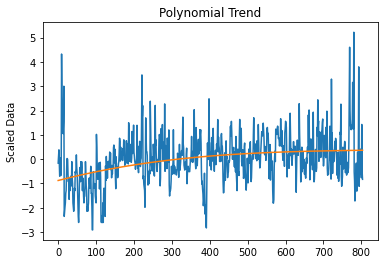

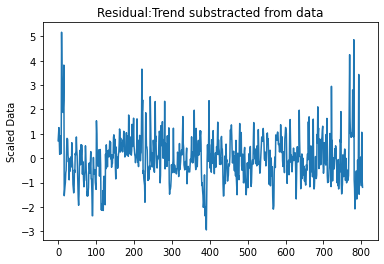

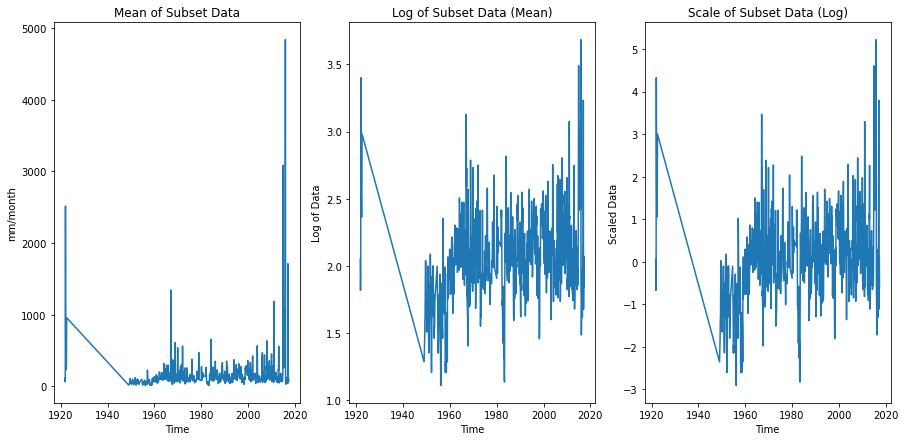

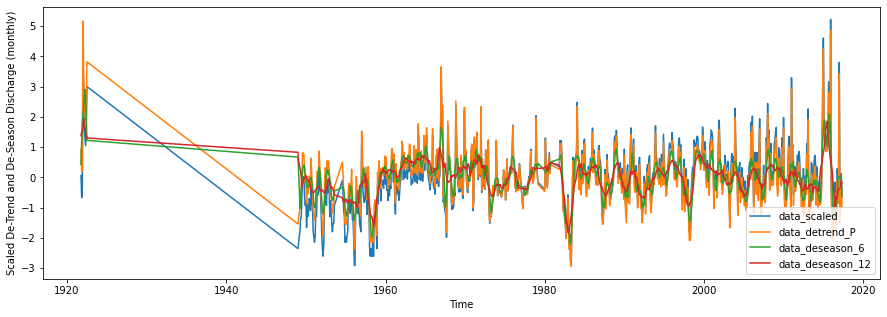

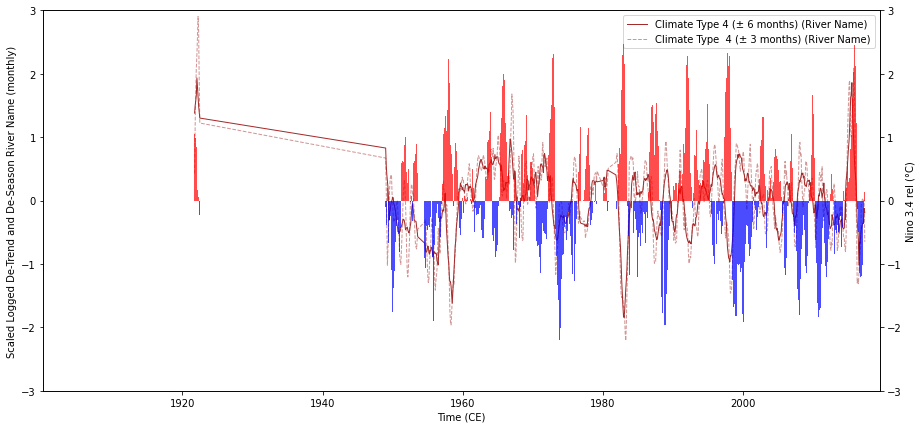

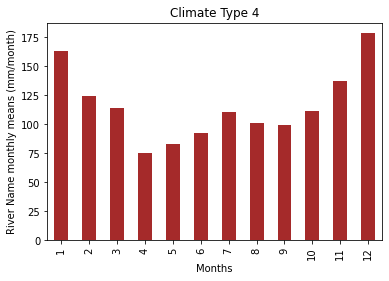

In [60]:
# give function criteria name and number, outputs river names, the mean of the rivers, and plotted with 
# given index and correlation coefficient 
# HESS colors: CTI - black ; CTII - green ; CTIII - purple; CTIV - brown; CPE I - indigo; CPE II - orange ; CPE III - piink ; 
# TRMM colors: Cluster1 - black; Cluster2 - green; Cluster3 - purple; Cluster4 - magenta; Cluster 5 - brown; Cluster 6 - grey

criteria_dis = pd.read_csv('../discharge/Data/Files/CriteriaTableDis_HESS.csv')
criteria_rain= pd.read_csv('../discharge/Data/Files/CriteriaTableRain_HESS.csv')


df_clean_clim_dis,std_dis  = clean_data(df_hess_hist_dropped,criteria_dis,'River Name','Climate Type',4,'Year','brown')
#df_clean_clim_rain,std_rain = clean_data( df_rain_dropped,criteria_rain,'Station Name','Climate Type',4,'Date','brown' ) #######



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


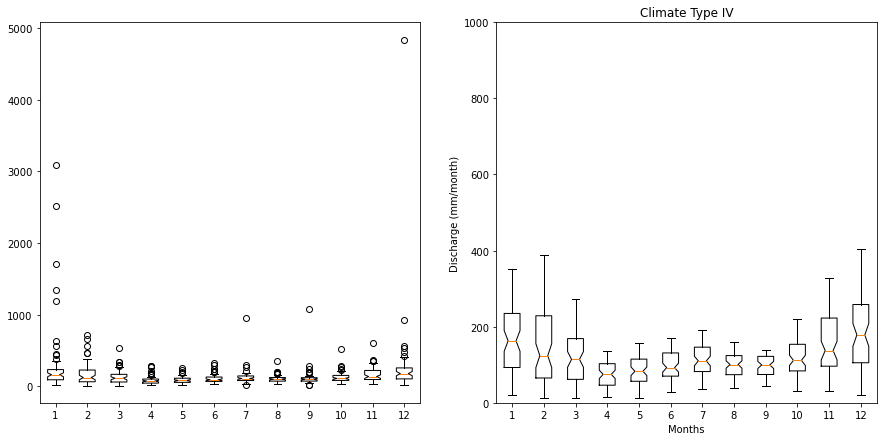

In [61]:
#BOX PLOT

month_list = [ i for i in range(1,13) ]
print(month_list)
month_group  = []

for  group in df_clean_clim_dis.groupby( df_clean_clim_dis['month'].dt.month ):
    month_group.append( list(group[1]['data_mean']) ) 
    
fig, ax = plt.subplots(figsize=(15,7), nrows = 1, ncols =2 )
ax[0].boxplot(list(month_group),whis=True,positions=month_list,notch=1,autorange=True,showfliers=True)
plt.xlabel('Months')
plt.ylabel('Discharge (mm/month)')
ax[1].boxplot(list(month_group),whis=True,positions=month_list,notch=1,autorange=True,showfliers=False)
plt.title('Climate Type IV')
plt.ylim( [0,1000] )
plt.savefig(f'../discharge/Data/Images/Nov19/BoxPlot_Dis_CT IV.png', dpi = 600)
plt.show()


/home/nsekhon/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Discharge Climate Type 4 (Remove Seasonality)
coefficient of determination: 0.0387
intercept: -0.0007
slope: [-0.11283986]


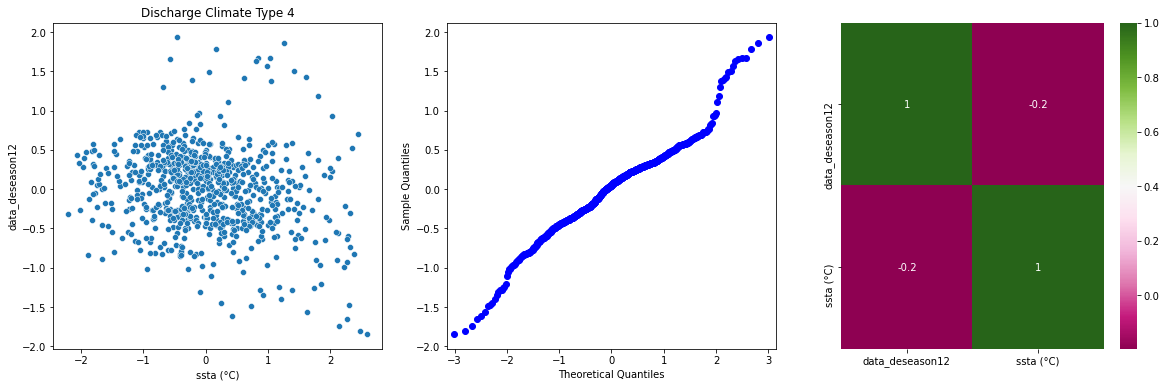

In [76]:
##### scatter and linear regression
# y = mx + b where x = ssta (indep), y = data_deseason(dep)
fig, (ax1, ax2,ax3) = plt.subplots(figsize=(20, 6),nrows=1,ncols=3)
sns.scatterplot(df_clean_clim_dis['ssta (°C)'],df_clean_clim_dis['data_deseason12'],ax=ax1).set_title('Discharge Climate Type 4') ########
sm.qqplot(df_clean_clim_dis['data_deseason12'], ax=ax2) ###########
sns.heatmap( df_clean_clim_dis.drop(['data_log', 'date', 'std', 'data_mean', 'data_scaled', 'data_detrend_L', ########
       'data_detrend_P', 'data_deseason','Year','time'], axis=1 ).corr(), annot=True, cmap='PiYG');########
plt.savefig('Discharge Climate Type 4 (Remove Seasonal).png', dpi = 600) ########


x = df_clean_clim_dis['ssta (°C)'].values.reshape(-1, 1)
y = df_clean_clim_dis['data_deseason12'] ######
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('Discharge Climate Type 4 (Remove Seasonality)') ########
print('coefficient of determination:', "{:.4f}".format(r_sq) )
print('intercept:', "{:.4f}".format(model.intercept_) )
print('slope:', model.coef_ )

In [ ]:
# SLIDING FUNCTION

df_data_table = slide_func( [-2.0,-3],df_clean_clim_rain,std_rain, 'ssta (°C)','data_deseason12', 3, 36,'la nina') 

In [ ]:
# raw plot ONLY
color = cm.rainbow(np.linspace(0, 1, 53))

fig, ax1 = plt.subplots(figsize=(20,14))
ax2 = ax1.twinx()

for i,c in zip(range(1,53),color):
    ax1.plot(df_hess['Year'],df_hess.iloc[:,i], c=c,label = df_hess.columns[i])
ax2.plot(df_nino34a_qc['date'],df_nino34a_qc['ssta (°C)'],'k')
ax1.legend(loc='best')
ax1.set_ylim(0,5000)
ax1.set_xlim([datetime.date(1940, 1, 26), datetime.date(2018, 2, 1)])
ax1.set_ylabel('Rivere Discharge (mm/month)', color='g')
ax2.set_ylabel('Nino 3.4 (°C)', color='b')
plt.show()

# Log Normalize Data and Hist Plot
f, axes = plt.subplots(2, 1, figsize=(10, 10), sharex= True)
sns.histplot(data=np.log10(df_hess.iloc[:,1:-1]),element="step",fill=True, 
             ax=axes[0], legend = False).set(title='Log Tranformed Discharge Data')
# Then standardize data 
scaler = preprocessing.scale(np.log10(df_hess.iloc[:,1:-1]))
sns.histplot(data=scaler,element="step",fill=True,
             ax=axes[1], legend = False).set(title='SCALED Log Tranformed Discharge Data')
#plt.setp(axes, yticks=[])
plt.tight_layout()
#plt.savefig("phil_log_hist.png",dpi=600)
plt.show()

In [ ]:
# Reading ESST, SOI, JMASST indexes

df_jmasst_qc = qc_index1(df_jmasst)
df_ersst_qc  = qc_index3(df_ersst)
df_soi_qc    = qc_index4(df_soi)

# Plot
f = plt.figure()
f.set_figwidth(24)
f.set_figheight(16)
plt.plot(df_jmasst_qc['Time'],df_jmasst_qc['sst'])
plt.xlabel('Time (years)')
plt.ylabel('ssta (°C)')
plt.title('JMASST')
plt.show()
# Bar Plot
fig, ax = plt.subplots(figsize=(24, 16))
# Add x-axis and y-axis
ax.bar(df_soi_qc['Time'],df_soi_qc['soi'], width = 30,color=(df_soi_qc['soi'] > 0).map({True: 'b',False: 'r'}))
# Set title and labels for axes
ax.set(xlabel="Time",ylabel="SOI",title="SOI Index")
# Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
# ROLLING SINE WAVE EXAMPLE

time_sine        = np.arange(1, 32, 1)
print(time_sine)
amplitude        = np.sin(time_sine) 
df_test = pd.DataFrame({'x':time_sine, 'y':amplitude})
plt.plot( df_test['x'], df_test['y'] )
df_new           = pd.DataFrame(df_test['y'])
df_test['z']    = df_new.rolling(window=6, center=True).mean()
plt.plot( df_test['x'], df_test['z'],'k' )
plt.show()

In [ ]:
# SAV GOL SINE WAVE EXAMPLE

x = np.arange(1, 24, 1)
y = np.sin(x) 
yhat = savgol_filter(y, 7, 1,mode='nearest')
scaler = StandardScaler()
norm = MinMaxScaler()
yhat_reshape = yhat.reshape(-1, 1)
# transform data
scaled = scaler.fit_transform(yhat_reshape)
normed = norm.fit_transform(yhat_reshape)
plt.plot(x, y)
plt.plot(x,yhat, color='green')
plt.plot(x,scaled, color='black')
plt.plot(x,normed, color='red')
plt.show()

/home/nsekhon/.local/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


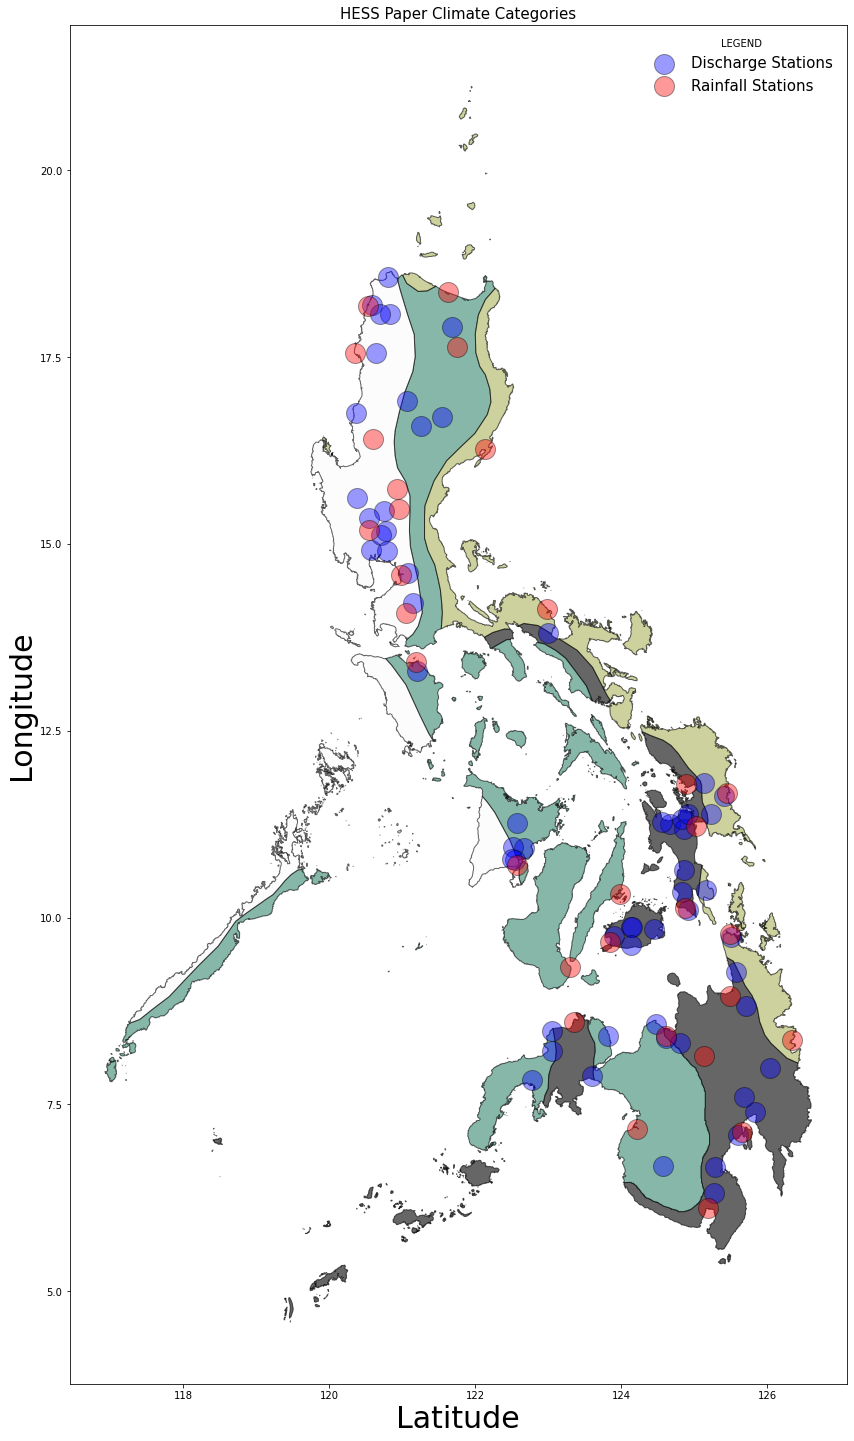

In [13]:
# Plot map with station locations    
# Make sure the coordinates are in order 
df_coords_dis = pd.read_csv('../discharge/Data/Files/CoordinatesDis.csv')
df_coords_dis['coords'] = list( zip(df_coords_dis.Lon, df_coords_dis.Lat) )


df_coords_rain = pd.read_csv('../discharge/Data/Files/CoordinatesRiver.csv')
df_coords_rain['coords']= list( zip(df_coords_rain.Lon, df_coords_rain.Lat) )

geo_df_dis = gpd.GeoDataFrame( df_coords_dis, crs  ={'init': 'epsg:4326'},
                          geometry = df_coords_dis['coords'].apply(Point) ).to_crs(epsg=4326)

geo_df_rain= gpd.GeoDataFrame( df_coords_rain, crs ={'init': 'epsg:4326'},
                              geometry = df_coords_rain['coords'].apply(Point) ).to_crs(epsg=4326) #3857 for the terrain map


#for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['River Name']):
    #ax.annotate(label, xy=(x, y), xytext=(4, -2), textcoords="offset points")
    
#add_basemap(ax, zoom=9,url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png' )

df_shape=gpd.read_file('../discharge/Data/Files/PHL_climatetype.shp')
fig, ax = plt.subplots(figsize = (25,25) )
df_shape.plot( ax=ax, alpha = 0.6, cmap='gist_earth',edgecolor = 'black', )
geo_df_dis.plot( ax=ax, alpha = 0.4, color = 'blue', markersize = 400,edgecolor = 'black', label = 'Discharge Stations'  )
geo_df_rain.plot( ax=ax, alpha = 0.4,color = 'red', markersize = 400,edgecolor = 'black', label = 'Rainfall Stations'  )
plt.title('HESS Paper Climate Categories',fontsize=15)
plt.xlabel('Latitude',fontsize=30)
plt.ylabel('Longitude',fontsize=30)
plt.legend( fontsize=15,frameon=False,title='LEGEND' )
plt.savefig( 'paired_rain_dis_map.png',dpi=600 )
plt.show()